In [1]:
import numpy as np                     # Llibreria matemÃ tica
import matplotlib.pyplot as plt        # Per mostrar plots
import sklearn                         # Llibreia de DM
import sklearn.datasets as ds            # Per carregar mÃ©s facilment el dataset digits
import sklearn.model_selection as cv    # Pel Cross-validation
import sklearn.neighbors as nb           # Per fer servir el knn
from sklearn.model_selection import cross_val_score  
import pandas as pd

In [2]:
data = pd.read_csv('games_clean.csv')

In [19]:
column = data.columns.get_loc('Metacritic')
y = data.iloc[:,column]
X = data.loc[:, data.columns != 'Metacritic']


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)
y_train


1480    Good
1513    Good
601     Good
2016    Good
885     Good
        ... 
1296    Good
563     Good
298     Good
319     Good
141     Good
Name: Metacritic, Length: 1540, dtype: object

## Normalization
Data should be numerical and normalized or standarized before using an SVM.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
# Apply the normalization trained in training data in both training and test sets
X_train = scaler.transform(X_train)
scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_test)

X_test = scaler.transform(X_test)

## Linear SVM

Let's try an SVM with default parameters. Linear means that we are not using any kernel to move the data to a higher dimensional space.

In [6]:
from sklearn.svm import SVC
knc = SVC(kernel='linear')
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("Confusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))

Confusion matrix on test set:
 [[  2   9   2]
 [ 12 483  48]
 [  1  79  24]]

Accuracy on test set:  0.7712121212121212


Not bad results. However, the linear SVM has parameter C that has to be adjusted. We will use *GridSearch* method to find the optimal value of C like we did in a previous notebook with the k value of the KNN algorithm.  

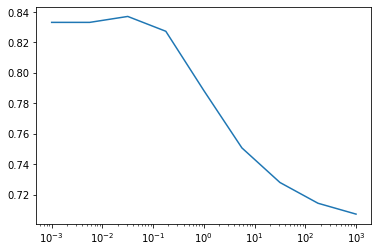

Acc. 4-fold cross on train data=  0.8370129870129871

Confusion matrix on test set:
 [[  0  13   0]
 [  0 541   2]
 [  0  98   6]]

Accuracy on test set:  0.8287878787878787

Best value of parameter C found:  {'C': 0.03162277660168379}

Number of supports:  685 ( 416 of them have slacks)
Prop. of supports:  0.4448051948051948


In [33]:
from sklearn.model_selection import GridSearchCV

# List of C values to test. We usualy test diverse orders of magnitude
Cs = np.logspace(-3, 3, num=9, base=10.0)

param_grid = {'C': Cs}
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=7, n_jobs=-1)
grid_search.fit(X_train,y_train)

# Let's plot the 10-fold cross.validation accuracy deppending on C
scores = grid_search.cv_results_['mean_test_score']
plt.semilogx(Cs,scores)
plt.show()

parval=grid_search.best_params_
cvacc = cross_val_score(SVC(C=parval['C'],kernel='linear'), X=X_train,  y=y_train, cv=10, scoring='accuracy')
print('Acc. 4-fold cross on train data= ', cvacc.mean())


# Let's apply the best C parameter found to the test set

knc = SVC(C=parval['C'],kernel='linear')
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("\nConfusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))
print("\nBest value of parameter C found: ",parval)
print("\nNumber of supports: ",np.sum(knc.n_support_), "(",np.sum(np.abs(knc.dual_coef_)==parval['C']) ,"of them have slacks)")
print("Prop. of supports: ",np.sum(knc.n_support_)/X_train.shape[0])


How the C parameter affects performance on training and test sets. 

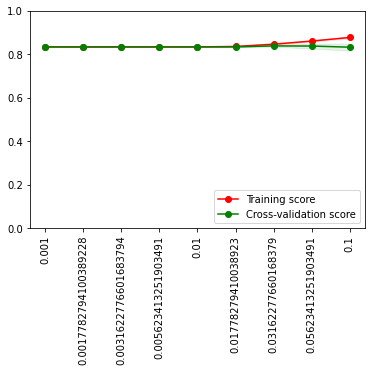

In [8]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(parameter_values, train_scores, validation_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc=4)

training_scores, test_scores = validation_curve(SVC(kernel='linear'), X_train, y_train, param_name="C", param_range=Cs,cv=4)
plot_validation_curve(range(len(Cs)), training_scores, test_scores)
plt.xticks(range(len(Cs)), Cs,rotation='vertical');
plt.ylim([0, 1])
plt.show()

## Polynomial kernels
We'll try first ploynomial kernel with degree 2 with default parameters.

In [9]:
knc = SVC(kernel='poly',degree =2) 
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("Confusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))


Confusion matrix on test set:
 [[  1  11   1]
 [  3 502  38]
 [  0  89  15]]

Accuracy on test set:  0.7848484848484848


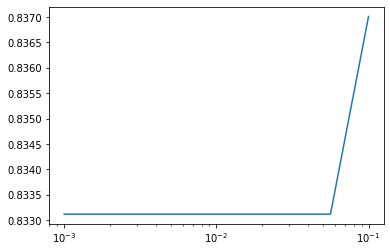

Acc. 10-fold cross on train data=  0.8344155844155845

Confusion matrix on test set:
 [[  0  13   0]
 [  0 541   2]
 [  0  99   5]]

Accuracy on test set:  0.8272727272727273

Best combination of parameters found:  {'C': 0.1}

Number of supports:  725 ( 394 of them have slacks)
Prop. of supports:  0.4707792207792208


In [10]:
Cs = np.logspace(-3, -1, num=9, base=10.0)

param_grid = {'C': Cs}
grid_search = GridSearchCV(SVC(kernel='poly',degree =2) , param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train,y_train)

scores = grid_search.cv_results_['mean_test_score']

plt.semilogx(Cs,scores)
plt.show()

parval=grid_search.best_params_

cvacc = cross_val_score(SVC(kernel='poly',degree =2,C=parval['C']) , X=X_train,  y=y_train, cv=10, scoring='accuracy')
print('Acc. 10-fold cross on train data= ', cvacc.mean())


knc = SVC(kernel='poly',degree =2,C=parval['C']) 
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("\nConfusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))
print("\nBest combination of parameters found: ",parval)
print("\nNumber of supports: ",np.sum(knc.n_support_), "(",np.sum(np.abs(knc.dual_coef_)==parval['C']) ,"of them have slacks)")
print("Prop. of supports: ",np.sum(knc.n_support_)/X_train.shape[0])

In [34]:
knc = SVC(kernel='poly',degree =3)
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("Confusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))


Confusion matrix on test set:
 [[  0  10   3]
 [  6 457  80]
 [  0  71  33]]

Accuracy on test set:  0.7424242424242424


## RBF Kernel
RBF with default parameters.

In [12]:
knc = SVC() 
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("Confusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))

Confusion matrix on test set:
 [[  0  13   0]
 [  0 543   0]
 [  0 104   0]]

Accuracy on test set:  0.8227272727272728


C parameter and the gamma parameter

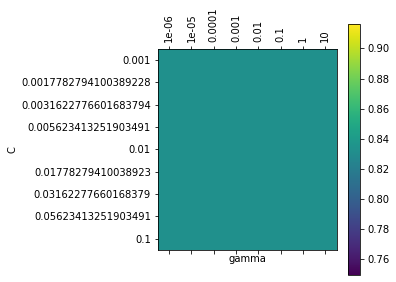


Best combination of parameters found:  {'C': 0.001, 'gamma': 1e-06}

Acc. 10-fold cross on train data=  0.8331168831168831


In [13]:
# Values we will test for each parameter. When observin results, consider the limits of the 
# values tested and increase them if necessary 
gammas = [0.000001,0.00001, 0.0001,0.001,0.01,0.1,1,10]
Cs = np.logspace(-3, -1, num=9, base=10.0)

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(), param_grid,  cv=4, n_jobs=-1)
grid_search.fit(X_train,y_train)
parval=grid_search.best_params_

# We'll show in a grid, the accuracy for each combination of parameters tester
scores = grid_search.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.matshow(scores)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'],rotation='vertical')
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.show()
parval=grid_search.best_params_
print("\nBest combination of parameters found: ",parval)


cvacc = cross_val_score(SVC(C=parval['C'], gamma=parval['gamma']) , X=X_train,  y=y_train, cv=4, scoring='accuracy')
print('\nAcc. 10-fold cross on train data= ', cvacc.mean())
